# 1. Video Processing

In [44]:
import cv2
import math
import numpy as np

In [84]:
%install_ext https://raw.github.com/cpcloud/ipython-autotime/master/autotime.py
%load_ext autotime

/Users/Amiros/anaconda/lib/python3.5/site-packages/IPython/core/magics/extension.py:47: UserWarning: %install_ext` is deprecated, please distribute your extension as a python package.
  "as a python package.", UserWarning)


Installed autotime.py. To use it, type:
  %load_ext autotime


In [ ]:
# setting up the file
videoFile = 'debate_sample.mp4'
vidcap = cv2.VideoCapture(videoFile)
success,image = vidcap.read()

# setting up parameters
seconds = 5
fps = int(round(vidcap.get(cv2.CAP_PROP_FPS))) # Gets the frames per second
multiplier = fps * seconds

In [ ]:
# extarcting every frame
count = 0;
while success:
  success,image = vidcap.read()
  if count % multiplier == 0:
      cv2.imwrite("debate_frames/frame%d.jpg" % count, image)     # save frame as JPEG file
  
  if cv2.waitKey(10) == 27:                     # exit if Escape is hit
      break
  count += 1

In [ ]:
# saving on S3 maybe? https://aws.amazon.com/articles/3998

#### https://github.com/Microsoft/Cognitive-Face-Python/blob/master/cognitive_face/face.py ####

# 2. Detecting gender in the images

In [2]:
import cognitive_face as CF
from cognitive_face import util

In [68]:
CF.Key.set('d78211e12bba41a991382ade5d68745b') #set the key

In [69]:
def detect(image, face_id=True, landmarks=False, faceRectangle= False, attributes='gender'):
    
    url = 'detect'
    headers, data, json = util.parse_image(image)
    params = {
        'returnFaceId': face_id and 'true' or 'false',
        'returnFaceLandmarks': landmarks and 'true' or 'false',
        'returnFaceAttributes': attributes,
    }

    return util.request('POST', url, headers=headers, params=params, json=json,
                        data=data)

In [82]:
import glob
from numpy import array

# selecting the filder for images
image_list = array(glob.glob("sampledebate_frames/*.jpg"))

In [222]:
#initiating face detection
all_images = []

for i,image in np.ndenumerate(image_list):
#    all_images.append(detect(image))

status_code: 429
response: 
					{ "error": { "code": "RateLimitExceeded", "message": "Rate limit is exceeded. Try again later." } }
		        	


CognitiveFaceException: Error when calling Cognitive Face API:
	status_code: 429
	code: RateLimitExceeded
	message: Rate limit is exceeded. Try again later.


time: 32.9 s


In [258]:
images_dict =[]
for i, instance in np.ndenumerate(all_images):
    for j, attr in np.ndenumerate(instance):
        images_dict.append(attr)

time: 2.3 ms


In [238]:
def flattenjson( b, delim ):
    val = {}
    for i in b.keys():
        if isinstance( b[i], dict ):
            get = flattenjson( b[i], delim )
            for j in get.keys():
                val[ i + delim + j ] = get[j]
        else:
            val[i] = b[i]

    return val

time: 6.89 ms


In [176]:
import itertools
from operator import itemgetter

for key, group in itertools.groupby(a, key=lambda x:x['faceAttributes']):
   print(key,)

{'gender': 'male'}
{'gender': 'female'}
{'gender': 'male'}
{'gender': 'female'}
{'gender': 'male'}
{'gender': 'female'}
{'gender': 'male'}
{'gender': 'female'}
{'gender': 'male'}
{'gender': 'female'}
{'gender': 'male'}
{'gender': 'female'}
{'gender': 'male'}
{'gender': 'female'}
{'gender': 'male'}
{'gender': 'female'}
{'gender': 'male'}
{'gender': 'female'}
{'gender': 'male'}
{'gender': 'female'}
{'gender': 'male'}
{'gender': 'female'}
{'gender': 'male'}
{'gender': 'female'}
{'gender': 'male'}
{'gender': 'female'}
{'gender': 'male'}
{'gender': 'female'}
{'gender': 'male'}
{'gender': 'female'}
{'gender': 'male'}
{'gender': 'female'}
{'gender': 'male'}
{'gender': 'female'}
{'gender': 'male'}
{'gender': 'female'}
{'gender': 'male'}
{'gender': 'female'}
{'gender': 'male'}
{'gender': 'female'}
{'gender': 'male'}
{'gender': 'female'}
{'gender': 'male'}
{'gender': 'female'}
{'gender': 'male'}
{'gender': 'female'}
{'gender': 'male'}
{'gender': 'female'}
{'gender': 'male'}
{'gender': 'female'}


In [ ]:
# the idea is to go through the whole fodler,
# put everything in a dataframe,
# and group them by gender

## or I can use an album of H&T photos and then assign them to the respective ones


# 3. Grouping

In [ ]:
def group(face_ids):
    """Divide candidate faces into groups based on face similarity.
    Args:
        face_ids: An array of candidate `face_id`s created by `face.detect`.
            The maximum is 1000 faces.
    Returns:
        one or more groups of similar faces (ranked by group size) and a
        messyGroup.
    """
    url = 'group'
    json = {
        'faceIds': face_ids,
    }

    return util.request('POST', url, json=json)

In [ ]:
idLists = ('0f3399c9-7416-4203-b101-c42b5c1fbe3f', '25b2310b-ba4c-4d9f-a177-39ec1fb7fcf7', 'a1d34384-b6c2-404d-90eb-840815d61d64', '29ba22bf-2284-4cb0-a0a6-771ce0a47f1a') 

In [ ]:
group1 = group(idLists)

In [ ]:
group1['groups']

# 4. Emotion of groups

In [188]:
import http.client, urllib, base64

#body = '/Users/Amiros/GitHub/debate/images/frame11.jpg'

time: 1.54 ms


In [189]:
# Variables

_url = 'https://api.projectoxford.ai/emotion/v1.0/recognize'
_key = '183aea69820e4dfda0176db816fc1f72' #Here you have to paste your primary key
_maxNumRetries = 5

time: 1.86 ms


In [190]:
import time 
import requests
import cv2
import operator
import numpy as np
from __future__ import print_function

# Import library to display results
import matplotlib.pyplot as plt
%matplotlib inline 
# Display images within Jupyter

time: 530 ms


In [191]:
def processRequest( json, data, headers, params ):

    """
    Helper function to process the request to Project Oxford

    Parameters:
    json: Used when processing images from its URL. See API Documentation
    data: Used when processing image read from disk. See API Documentation
    headers: Used to pass the key information and the data type request
    """

    retries = 0
    result = None

    while True:

        response = requests.request( 'post', _url, json = json, data = data, headers = headers, params = params )

        if response.status_code == 429: 

            print( "Message: %s" % ( response.json()['error']['message'] ) )

            if retries <= _maxNumRetries: 
                time.sleep(1) 
                retries += 1
                continue
            else: 
                print( 'Error: failed after retrying!' )
                break

        elif response.status_code == 200 or response.status_code == 201:

            if 'content-length' in response.headers and int(response.headers['content-length']) == 0: 
                result = None 
            elif 'content-type' in response.headers and isinstance(response.headers['content-type'], str): 
                if 'application/json' in response.headers['content-type'].lower(): 
                    result = response.json() if response.content else None 
                elif 'image' in response.headers['content-type'].lower(): 
                    result = response.content
        else:
            print( "Error code: %d" % ( response.status_code ) )
            print( "Message: %s" % ( response.json()['error']['message'] ) )

        break
        
    return result

time: 29.2 ms


In [263]:
urlImage2 = 'https://raw.githubusercontent.com/Microsoft/ProjectOxford-ClientSDK/master/Face/Windows/Data/detection3.jpg'
urlImage = 'https://s3-us-west-2.amazonaws.com/debateinemotion/T/t1.png'



headers = dict()
headers['Ocp-Apim-Subscription-Key'] = _key
headers['Content-Type'] = 'application/json' 

json = { 'url': urlImage2 } 
data = None
params = None

result = processRequest( json, data, headers, params )

time: 2.93 s


In [264]:
result

[{'faceRectangle': {'height': 140, 'left': 216, 'top': 143, 'width': 140},
  'scores': {'anger': 4.857832e-09,
   'contempt': 3.60886387e-09,
   'disgust': 1.88275351e-09,
   'fear': 8.208998e-10,
   'happiness': 0.99999994,
   'neutral': 1.58002855e-08,
   'sadness': 2.58834572e-08,
   'surprise': 3.569176e-08}},
 {'faceRectangle': {'height': 138, 'left': 378, 'top': 239, 'width': 138},
  'scores': {'anger': 4.67109421e-05,
   'contempt': 9.014235e-05,
   'disgust': 7.946587e-05,
   'fear': 0.0564681776,
   'happiness': 5.95064048e-05,
   'neutral': 0.5410432,
   'sadness': 0.299806863,
   'surprise': 0.102405921}}]

time: 4.68 ms


## 4.1 visualizing the image on jupyter

In [198]:
def renderResultOnImage( result, img ):
    
    """Display the obtained results onto the input image"""
    
    for currFace in result:
        faceRectangle = currFace['faceRectangle']
        cv2.rectangle( img,(faceRectangle['left'],faceRectangle['top']),
                           (faceRectangle['left']+faceRectangle['width'], faceRectangle['top'] + faceRectangle['height']),
                       color = (255,0,0), thickness = 5 )


    for currFace in result:
        faceRectangle = currFace['faceRectangle']
        currEmotion = max(currFace['scores'].items(), key=operator.itemgetter(1))[0]


        textToWrite = "%s" % ( currEmotion )
        cv2.putText( img, textToWrite, (faceRectangle['left'],faceRectangle['top']-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 1 )

time: 9.79 ms


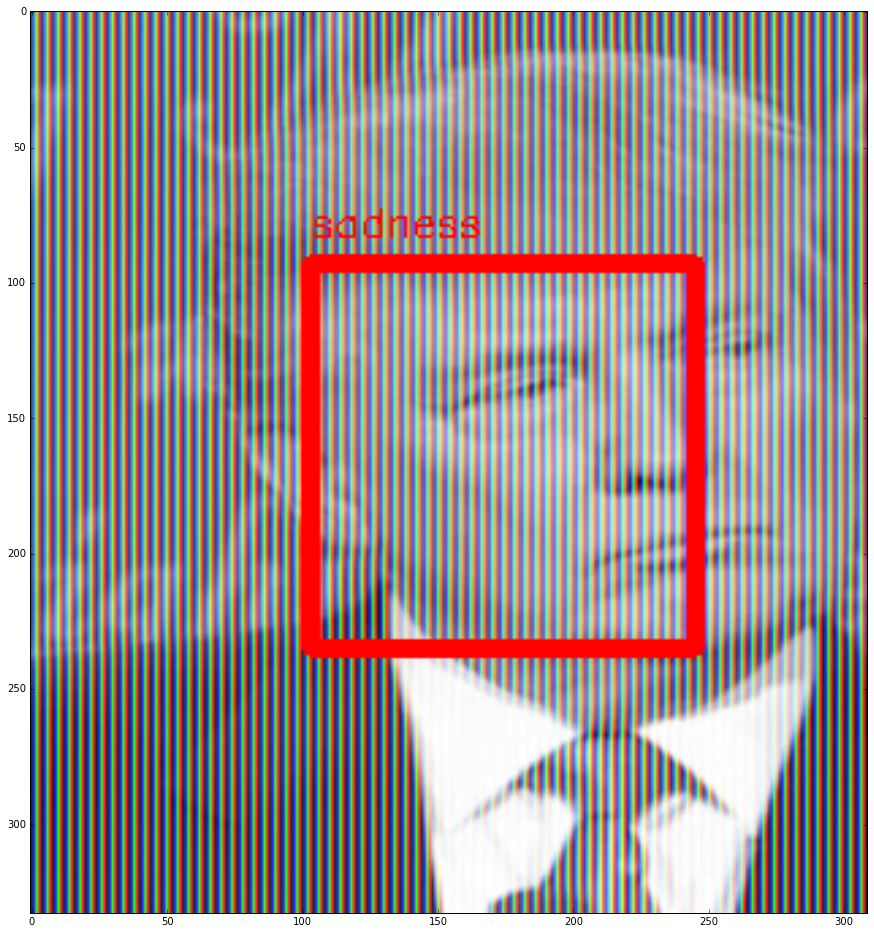

time: 2.98 s


In [195]:
if result is not None:
    # Load the original image, fetched from the URL
    arr = np.asarray( bytearray( requests.get( urlImage ).content ), dtype=np.uint8 )
    img = cv2.cvtColor( cv2.imdecode( arr, -1 ), cv2.COLOR_BGR2RGB )

    renderResultOnImage( result, img )

    ig, ax = plt.subplots(figsize=(15, 20))
    ax.imshow( img )